# Importing libraries

In [4]:
import pandas as pd
import numpy as np

# Model Related - Transformers from Hugging Face API
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

# Visualization
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('data/Reviews.csv')

In [6]:
print("Shape:", df.shape)
print(df.columns)

Shape: (568454, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [7]:
# Removing unnecessary columns
df.drop(['UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary'], axis=1, inplace=True)
print(df.columns)

Index(['Id', 'ProductId', 'Score', 'Text'], dtype='object')


In [8]:
# Get unique products - 74,258

product_list = df['ProductId'].unique()
len(product_list)

74258

In [9]:
df['ProductId'].value_counts()
# Most reviewd product = B007JFMH8M

B007JFMH8M    913
B0026RQTGE    632
B002QWHJOU    632
B002QWP89S    632
B002QWP8H0    632
             ... 
B004DSPTTM      1
B008C9QWU8      1
B007O5A6BM      1
B003Q4TZ08      1
B001LR2CU2      1
Name: ProductId, Length: 74258, dtype: int64

# EDA

In [10]:
# Data Frame of most reviewed product

prod_1 = df.loc[df['ProductId'] == 'B007JFMH8M'].reset_index(drop=True)
prod_1.head()

,Id,ProductId,Score,Text
0,562971,B007JFMH8M,5,I love these cookies! Not only are they healt...
1,562972,B007JFMH8M,5,Quaker Soft Baked Oatmeal Cookies with raisins...
2,562973,B007JFMH8M,5,I am usually not a huge fan of oatmeal cookies...
3,562974,B007JFMH8M,5,I participated in a product review that includ...
4,562975,B007JFMH8M,5,My kids loved these. I was very pleased to giv...


In [11]:
# Pretrained Model

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

## Text Preprocessing

In [12]:
def preprocess(text: str) -> str:
    new_text = []

    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

## Analysis Function

In [13]:
# Function for Roberta Model
def roberta_analyze(sentence: str) -> dict:
    processed_sentence = preprocess(sentence)
    encoded_text = tokenizer(processed_sentence, return_tensors='pt', truncation=True, max_length=50)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

scores = list()
texts = prod_1['Text']
for row in texts:
    scores_dict = roberta_analyze(row)
    scores.append(scores_dict)

scores = pd.DataFrame(scores)
scores.head(20)

,roberta_neg,roberta_neu,roberta_pos
0,0.001569,0.006234,0.992197
1,0.001055,0.018822,0.980123
2,0.002012,0.011959,0.986029
3,0.030037,0.876413,0.093550
4,0.001159,0.007344,0.991497
5,0.001197,0.007010,0.991793
6,0.009592,0.154376,0.836032
7,0.003304,0.018436,0.978260
8,0.004561,0.458991,0.536449
9,0.001673,0.009471,0.988856


In [14]:
prod_1 = prod_1.join(scores)

In [15]:
temp = prod_1[prod_1['Score'] == 1]
temp = temp.reset_index(drop=True)
temp

,Id,ProductId,Score,Text,roberta_neg,roberta_neu,roberta_pos
0,563627,B007JFMH8M,1,I tried one: gave it two bites (to be sure) an...,0.176097,0.277575,0.546328
1,563846,B007JFMH8M,1,"The Quaker Soft Baked Oatmeal Cookie, Raisins ...",0.135749,0.326584,0.537668
2,563872,B007JFMH8M,1,"My kids or I didn't care for it much, they tos...",0.887839,0.103565,0.008596
3,563873,B007JFMH8M,1,If I could give it zero stars I would......hor...,0.924334,0.066396,0.009270


In [16]:
prod_1.describe()

,Id,Score,roberta_neg,roberta_neu,roberta_pos
count,913.000000,913.000000,913.000000,913.000000,913.000000
mean,563427.000000,4.582694,0.038871,0.066221,0.894909
std,263.704696,0.705560,0.136333,0.131957,0.226885
min,562971.000000,1.000000,0.000874,0.004518,0.003460
25%,563199.000000,4.000000,0.001389,0.007902,0.953985
50%,563427.000000,5.000000,0.001876,0.013525,0.984676
75%,563655.000000,5.000000,0.004583,0.040985,0.990555
max,563883.000000,5.000000,0.962296,0.876413,0.993642


# Visualization

(-1.0999999971630168,
 1.0999999998649055,
 -1.0999997498470235,
 1.09999976946331)

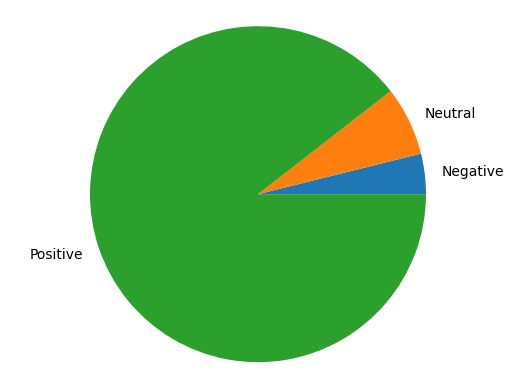

In [23]:
labels = ('Negative', 'Neutral', 'Positive')
test = prod_1[["roberta_neg", "roberta_neu", "roberta_pos"]].mean() # Pandas Series
avg_sentiments = [i for i in test]

# Pie Chart
fig1, ax1 = plt.subplots()
ax1.pie(avg_sentiments, labels=labels)
ax1.axis('equal')